In [72]:
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
n_qubits = 10
n_layers=2

In [73]:
I = np.array([[1, 0], [0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

# Rotation gate around Y-axis
def RY(theta):
    return np.array([
        [np.cos(theta/2), -np.sin(theta/2)],
        [np.sin(theta/2),  np.cos(theta/2)]
    ])

#Tensor product 
def kron_n(*ops):
    return reduce(np.kron, ops)


In [74]:
#initial state |000...0⟩
def initial_state(n):
    state = np.zeros(2**n, dtype=complex)
    state[0] = 1.0
    return state

In [75]:
#Construct full CNOT
def get_cnot_matrix(n_qubits, control, target):
    P0 = np.array([[1, 0], [0, 0]])  # |0⟩⟨0|
    P1 = np.array([[0, 0], [0, 1]])  # |1⟩⟨1|
    
    ops_0 = []
    ops_1 = []
    
    for i in range(n_qubits):
        if i == control:
            ops_0.append(P0)
            ops_1.append(P1)
        elif i == target:
            ops_0.append(I)
            ops_1.append(X)
        else:
            ops_0.append(I)
            ops_1.append(I)
    
    term1 = kron_n(*ops_0)
    term2 = kron_n(*ops_1)
    return term1 + term2

In [76]:
#Apply single-qubit gate
def apply_single_qubit_gate(state, gate, target, n_qubits):
    ops = [I] * n_qubits
    ops[target] = gate
    U = kron_n(*ops)
    return U @ state


In [77]:
#Applying CNOT
def apply_cnot(state, control, target, n_qubits):
    U_cnot = get_cnot_matrix(n_qubits, control, target)
    return U_cnot @ state

In [78]:
# ansatz state |ψ(θ)⟩ with multiple layers
def ansatz(theta, n_qubits, n_layers):
    assert len(theta) == n_layers * n_qubits, "theta must have n_layers * n_qubits elements"
    state = initial_state(n_qubits)
    for layer in range(n_layers):
        for i in range(n_qubits):
            angle = theta[layer * n_qubits + i]
            state = apply_single_qubit_gate(state, RY(angle), i, n_qubits)
        for i in range(n_qubits - 1):
            state = apply_cnot(state, i, i + 1, n_qubits)
    return state


In [79]:
#Hamiltonian H = Σ Z_i + Σ Z_i Z_{i+1}
def build_hamiltonian(n_qubits):
    H = np.zeros((2**n_qubits, 2**n_qubits), dtype=complex)
    # Single Z terms
    for i in range(n_qubits):
        ops = [I] * n_qubits
        ops[i] = Z
        H += kron_n(*ops)
    # Pairwise Z_i Z_{i+1}
    for i in range(n_qubits - 1):
        ops = [I] * n_qubits
        ops[i] = Z
        ops[i + 1] = Z
        H += kron_n(*ops)
    return H

In [80]:
#Expectation value ⟨ψ|H|ψ⟩
def expectation(theta, H, n_qubits):
    psi = ansatz(theta, n_qubits, n_layers)
    return np.real(np.vdot(psi, H @ psi))


In [81]:
H = build_hamiltonian(n_qubits)
def cost(theta):
    return expectation(theta, H, n_qubits)

In [124]:
#Optimising using Nelder-Mead algorithm
def nelder_mead(f, x_start, step=0.5, tol=1e-6, max_iter=500):
    n = len(x_start)
    # Initialize simplex
    f_history = []
    simplex = [x_start]
    for i in range(n):
        x = np.array(x_start, dtype=float)
        x[i] += step
        simplex.append(x)
    simplex = np.array(simplex)
    #$print(simplex)
    for iteration in range(max_iter):
        # Sort simplex points by function value
        simplex = sorted(simplex, key=f)
        f_values = [f(x) for x in simplex]

        # Check convergence
        if np.std(f_values) < tol:
            break

        # Compute centroid (excluding worst point)
        centroid = np.mean(simplex[:-1], axis=0)

        # Reflection
        xr = centroid + (centroid - simplex[-1])
        fr = f(xr)

        if f_values[0] <= fr < f_values[-2]:
            simplex[-1] = xr
        elif fr < f_values[0]:
            # Expansion
            xe = centroid + 2 * (xr - centroid)
            fe = f(xe)
            simplex[-1] = xe if fe < fr else xr
        else:
            # Contraction
            xc1 = simplex[-1] + 0.25 * (xr-simplex[-1] )   
            xc3 = simplex[-1] + 0.75 * (xr-simplex[-1] )
            fc1 = f(xc1)
            fc3 = f(xc3)
            xc = 0
            fc = 0
            if fc1 < fc3:
                xc,fc= xc1,fc1
            else:
                xc,fc = xc3,fc3
            if fc < f_values[-1]:
                simplex[-1] = xc1
            else:
                # Shrink
                for i in range(1, len(simplex)):
                    simplex[i] = simplex[0] + 0.5 * (simplex[i] - simplex[0])
        f_history.append(f_values[0])
    best = min(simplex, key=f)
    return best, f(best), iteration + 1,f_history


x0 = np.random.uniform(0, 2 * np.pi, n_qubits*n_layers)  # Initial guess
sol, fval, iters,fhisto = nelder_mead(cost, x0)
print("[Nelder-Mead] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩:", fval)
print("[Nelder-Mead] Optimal θ:", sol)
print("[Nelder-Mead] Iterations:", iters)
print(fhisto)

[Nelder-Mead] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩: -8.9834263876967
[Nelder-Mead] Optimal θ: [3.12300072 3.14391197 0.25027055 1.48714584 4.64183402 4.70378145
 4.77353915 4.72244455 1.56199077 4.71789761 6.27870808 2.77983155
 2.86399814 4.59078516 7.86947182 1.81299584 1.60078607 4.72373459
 4.7482165  4.327456  ]
[Nelder-Mead] Iterations: 500
[-1.0567982912305145, -1.74339207932235, -1.74339207932235, -1.74339207932235, -1.74339207932235, -1.74339207932235, -1.74339207932235, -1.74339207932235, -1.74339207932235, -1.74339207932235, -1.74339207932235, -1.74339207932235, -1.74339207932235, -1.74339207932235, -1.74339207932235, -1.74339207932235, -1.74339207932235, -1.74339207932235, -1.74339207932235, -2.2485491703086655, -2.2485491703086655, -2.2485491703086655, -2.2485491703086655, -2.2485491703086655, -2.2485491703086655, -2.2485491703086655, -2.2485491703086655, -2.2485491703086655, -2.2485491703086655, -2.2485491703086655, -2.2485491703086655, -2.8044928204298705, -2.8044928204298705, -2

In [ ]:
solnm= sol 

Sampled bitstrings: 20


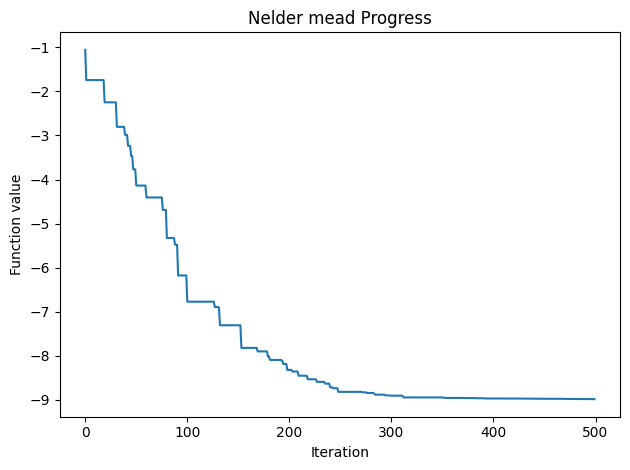

In [161]:
plt.plot(fhisto)
plt.xlabel('Iteration')
plt.ylabel('Function value')
plt.title('Nelder mead Progress')
plt.grid(False)
plt.tight_layout()
plt.show()

In [83]:
# Optimising using SPSA algorithm
a = 0.5
c = 0.1
A = 80
alpha = 0.602
gamma = 0.101
f_history = []

# Initial point
#theta =np.random.uniform(0, 3*np.pi, size=(n_layers*n_qubits))
theta=np.random.uniform(0, 2 * np.pi, n_qubits*n_layers)
max_iterations = 1000
tolerance = 1e-6
np.random.seed(42)

for k in range(max_iterations):
    ak = a / (A + k + 1)**alpha
    ck = c / (k + 1)**gamma
    delta = np.random.choice([-1, 1], size=n_qubits*n_layers)  #perturbation vector Δ_k from Bernoulli(±1)
    theta_plus = theta + ck * delta
    theta_minus = theta - ck * delta
    y_plus = cost(theta_plus)
    y_minus = cost(theta_minus)
    g_hat = (y_plus - y_minus) / (2 * ck) * (1.0 / delta)
    theta = theta - ak * g_hat
    f_val = cost(theta)
    f_history.append(f_val)
    if k > 0 and abs(f_history[-1] - f_history[-2]) < tolerance:
        #print(f"[SPSA] Stopped early at iteration {k+1}: Δf = {abs(f_history[-1] - f_history[-2]):.2e} < {tolerance}")
        break
print("[SPSA] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩:", f_val)
print("[SPSA] Optimal θ:", theta)
solspsa = theta
print("[SPSA] Iterations:", len(f_history))
print(f_history)


[SPSA] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩: -8.944645377059448
[SPSA] Optimal θ: [ 1.94848253 -1.61094921  1.63675408  4.72277526  1.51635734  7.8086887
  1.5213225   1.45093191  1.56896307 -1.55046438  5.0563735   4.70042307
  4.70442622  1.84504531  1.49222046  1.57789534  7.617491    1.48247292
  4.72111189  4.68995671]
[SPSA] Iterations: 230
[-0.09244256738778767, -1.3074790961186182, -1.379889343344906, -1.3835841657108843, -1.3896264212016005, -1.3903056139345757, -1.4324227636197535, -1.450567682357291, -1.544876734150541, -1.5520400739738118, -1.8819153100355872, -2.0380119679921673, -2.5345894863049985, -3.0436794580688966, -3.080477719916687, -3.1002508356382, -3.176496029625559, -3.191447016271219, -3.420278907906553, -3.4278143772336107, -3.432227262207472, -3.483563388153121, -3.578739473167027, -3.5808393253784976, -3.6632645655106377, -3.688486671881159, -3.6957525765208903, -3.704165775907487, -3.935374950197742, -3.9555718139340468, -3.972373194214918, -4.059779478394011, -4.0

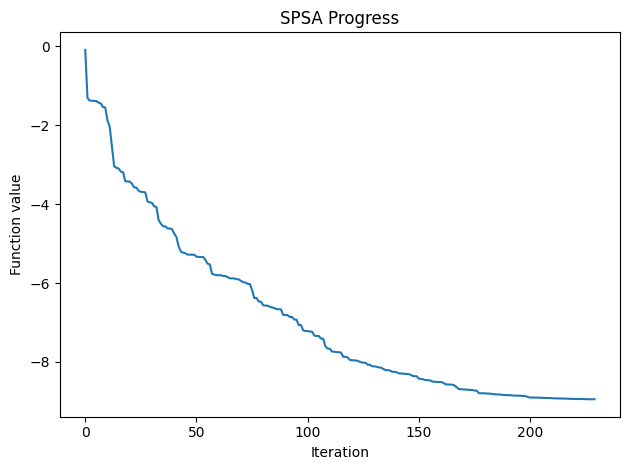

In [122]:
plt.plot(f_history)
plt.xlabel('Iteration')
plt.ylabel('Function value')
plt.title('SPSA Progress')
plt.grid(False)
plt.tight_layout()
plt.show()

In [86]:
#Optimising using L-BFGS algorithm
def lbfgs(f, grad_f, x0, m=50, tol=1e-6, max_iter=1000):
    x = x0.copy()
    k = 0  # iteration counter
    s_list = []   
    y_list = []   
    rho_list = [] 
    g = grad_f(x)
    f_histry = []
    BOUND = 0  # number of updates used
    while np.linalg.norm(g) > tol and k < max_iter:
        q = g.copy()
        alpha = []
        if k < m:
            INCR = 0
            BOUND = k
        else:
            INCR = k - m
            BOUND = m
        for i in range(BOUND - 1, -1, -1):
            j = i + INCR
            if j >= len(s_list):  # safety check
                continue
            s = s_list[j]
            y = y_list[j]
            rho = rho_list[j]
            alpha_i = rho * np.dot(s, q)
            alpha.append(alpha_i)
            q = q - alpha_i * y

        alpha = alpha[::-1]  # to use in forward loop later

        if k > 0:
            y_last = y_list[-1]
            s_last = s_list[-1]
            gamma = np.dot(s_last, y_last) / np.dot(y_last, y_last)
        else:
            gamma = 1.0
        r = gamma * q
        for i in range(0, BOUND):
            j = i + INCR
            if j >= len(s_list):  # safety check
                continue
            s = s_list[j]
            y = y_list[j]
            rho = rho_list[j]
            beta = rho * np.dot(y, r)
            r = r + s * (alpha[i] - beta)

        #search direction and backtracking line search
        p = -r
        t = 1.0
        while f(x + t * p) > f(x) + 1e-4 * t * np.dot(g, p):
            t *= 0.5
            if t < 1e-10:
                break
        #position and gradient update
        x_new = x + t * p
        g_new = grad_f(x_new)
        s_k = x_new - x
        y_k = g_new - g

        #store s_k, y_k, and ρ_k if curvature condition satisfied
        if np.dot(s_k, y_k) > 1e-10:
            s_list.append(s_k)
            y_list.append(y_k)
            rho_list.append(1.0 / np.dot(y_k, s_k))

            #maintaining memory size
            if len(s_list) > m:
                s_list.pop(0)
                y_list.pop(0)
                rho_list.pop(0)

        x = x_new
        g = g_new
        k += 1
        f_histry.append(f(x))
        #print(f"Iter {k:2d} | f(x) = {f(x):.6f} | ||grad|| = {np.linalg.norm(g):.2e}") 
    return x, f(x), k , f_histry


In [87]:
#writing a function grad that calculates gradient numerically 
def grad_numerical(func, v, h=1e-3):
    grad = np.zeros_like(v)
    for i in range(len(v)):
        v_plus = np.copy(v)
        v_minus = np.copy(v)
        v_plus[i] += h
        v_minus[i] -= h
        grad[i] = (func(v_plus) - func(v_minus)) / (2 * h)
    return grad

In [ ]:
x0 =np.random.uniform(0, 2 * np.pi, n_qubits*n_layers)  # Initial guess
xmin,fvalue,niter ,fhist= lbfgs(cost , lambda x: grad_numerical(cost, x), x0)
print("[L-BFGS] Optimal θ: ",xmin) 
sollbfgs= xmin
print("[L-BFGS] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩: ",fvalue)
print("[L-BFGS] Iterations:", niter)
print(fhist)

[L-BFGS] Optimal θ:  [5.72842734 4.1180932  1.57079637 1.57079609 4.71238898 1.57079629
 1.57079631 1.57079633 1.57079631 1.57079609 3.24132009 4.28907037
 1.57079632 4.71238898 4.71238898 1.5707963  1.57079629 1.57079631
 1.57079634 1.5707962 ]
[L-BFGS] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩:  -8.999999999999861
[L-BFGS] Iterations: 19
[-2.097433055952849, -4.869414048888578, -5.540343214248903, -8.327943210623003, -8.924284221017228, -8.989842032371309, -8.99789475213412, -8.999869546264904, -8.999936515054092, -8.999998155800728, -8.999999243893273, -8.999999952109464, -8.999999994888816, -8.999999999871639, -8.999999999991859, -8.999999999999028, -8.999999999999517, -8.999999999999744, -8.999999999999861]


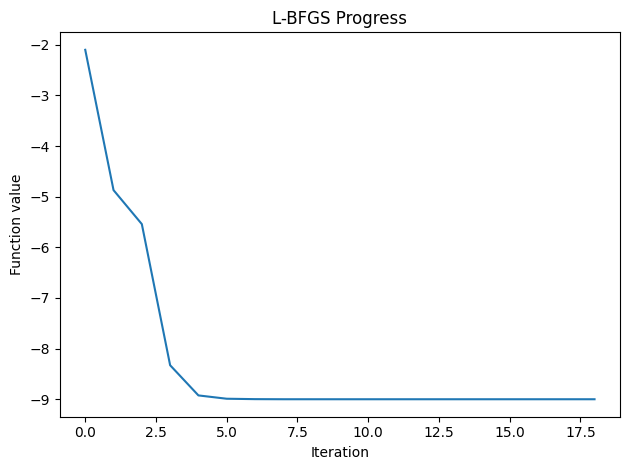

In [107]:
plt.plot(fhist)
plt.xlabel('Iteration')
plt.ylabel('Function value')
plt.title('L-BFGS Progress')
plt.grid(False)
plt.tight_layout()
plt.show()

In [89]:
#Optimizing using Adam algorithm
def adam_optimize(func, grad, theta_init, alpha=0.3, beta1=0.9, beta2=0.999,epsilon=1e-8, max_iters=100, tolerance=1e-6):
    theta = theta_init.copy()
    m = np.zeros_like(theta)
    v = np.zeros_like(theta)

    thetas = [theta.copy()]
    losses = [func(theta)]
    f_history = []
    for t in range(1, max_iters + 1):
        g = grad_numerical(func, theta)

        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * (g ** 2)

        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)

        theta = theta - alpha * m_hat / (np.sqrt(v_hat) + epsilon)

        f_val = func(theta)
        thetas.append(theta.copy())
        losses.append(f_val)
        f_history.append(f_val)
        # Early stopping based on function change
        if abs(losses[-1] - losses[-2]) < tolerance:
                #print(f"[Adam] Early stopping at iteration {t}: Δf = {abs(losses[-1] - losses[-2]):.2e} < {tolerance}")
                break

    return theta, losses, thetas, f_history


In [108]:

theta_init = np.random.uniform(0, 2 * np.pi, n_qubits*n_layers)  # Initial guess for θ
theta_opt, loss_history, theta_path,fhistory = adam_optimize(cost, lambda x: grad_numerical(cost, x), theta_init)
print(f"[Adam] Optimal θ: {theta_opt}")
soladam = theta_opt
print(f"[Adam] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩: {loss_history[-1]:.6f}") 
print(f"[Adam] Iterations: {len(loss_history)}")
print(fhistory)

[Adam] Optimal θ: [ 3.13163566  4.57365536  1.57283521  4.70810202  1.57160481 -1.57080288
  1.57126681  1.57470617  1.57112957  4.71424379 -0.06705472  4.53433408
  4.71425758  4.80108799  4.71894955 -1.63285988  1.56848246  1.56486366
  4.71543429  4.69619793]
[Adam] Optimal value ⟨ψ(θ)|H|ψ(θ)⟩: -8.999890
[Adam] Iterations: 101
[-2.45549273728241, -4.354047536936301, -5.4472226421083665, -6.3857187225392735, -7.437049469020286, -8.119812140271652, -8.21384474137406, -8.136120707195502, -8.165842230367456, -8.227299110965696, -8.244754741614187, -8.236575191004077, -8.243382703667985, -8.306307891375788, -8.43355703737329, -8.588158038149391, -8.712778029156318, -8.769698752692458, -8.766920000396672, -8.74053073186976, -8.721296017012751, -8.723986783857766, -8.753111871201634, -8.805545171136227, -8.86705281965715, -8.91586138392554, -8.935192617676398, -8.924234990706696, -8.898195163400842, -8.87757054018864, -8.876097230477473, -8.895542862751928, -8.926843109124649, -8.955005672

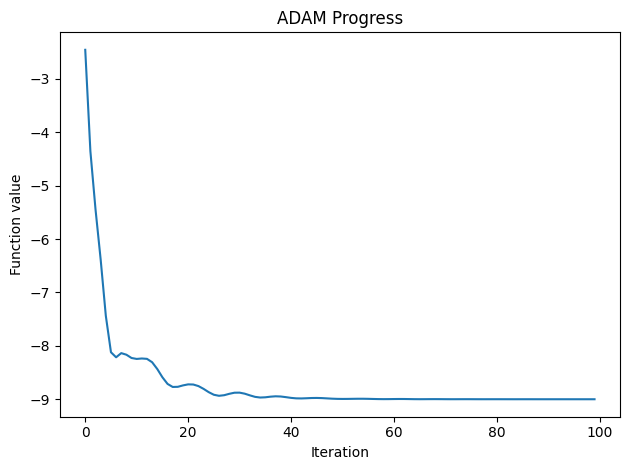

In [109]:
plt.plot(fhistory)
plt.xlabel('Iteration')
plt.ylabel('Function value')
plt.title('ADAM Progress')
plt.grid(False)
plt.tight_layout()
plt.show()

In [119]:
def bfgs(f, grad_f, x0, tol=1e-6, max_iter=100):
    x = x0.astype(float)
    trajectory = [x.copy()]
    n = len(x)
    H = np.eye(n)
    epsilon = 1e-10
    damping = 1e-4

    history = [f(x)] 
    direction_norms = []  # <-- new

    for i in range(max_iter):
        grad = grad_f(x)
        if np.linalg.norm(grad) < tol:
            print(f"Converged in {i} iterations.")
            break

        p = -H @ grad
        direction_norms.append(np.linalg.norm(p))  # <-- store norm of direction

        # Backtracking line search
        alpha = 1.0
        c, rho = 1e-4, 0.5
        while f(x + alpha * p) > f(x) + c * alpha * grad @ p:
            alpha *= rho

        x_new = x + alpha * p
        s = x_new - x
        y = grad_f(x_new) - grad

        ys = y @ s
        if ys < epsilon:
            y_damped = y + damping * s
            ys_damped = y_damped @ s
            if ys_damped < epsilon:
                print(f"Skipping update at iter {i}: even damped y.T@s is too small.")
                x = x_new
                history.append(f(x))
                continue
            else:
                y = y_damped
                ys = ys_damped

        rho = 1.0 / ys
        I = np.eye(n)
        H = (I - rho * np.outer(s, y)) @ H @ (I - rho * np.outer(y, s)) + rho * np.outer(s, s)

        x = x_new
        trajectory.append(x.copy())
        history.append(f(x))

    print("Final point:", x)
    print("Final function value:", f(x))
    return x, history  # <-- return norms too



In [120]:
x0 = np.random.uniform(0, 2 * np.pi, n_qubits*n_layers) # Initial guess
solution, history = bfgs(cost, lambda x: grad_numerical(cost, x), x0)
solbfgs = solution


Skipping update at iter 29: even damped y.T@s is too small.
Skipping update at iter 30: even damped y.T@s is too small.
Skipping update at iter 31: even damped y.T@s is too small.
Skipping update at iter 32: even damped y.T@s is too small.
Skipping update at iter 33: even damped y.T@s is too small.
Converged in 34 iterations.
Final point: [6.28318541e+00 3.14159272e+00 1.76000871e-07 3.07887602e+00
 1.57079597e+00 1.57079636e+00 1.57079633e+00 1.57079624e+00
 1.57079635e+00 7.85398165e+00 3.14159294e+00 6.28318538e+00
 6.28318541e+00 3.07887611e+00 7.85398200e+00 1.57079635e+00
 1.57079633e+00 5.42855966e+00 1.57079629e+00 1.57079629e+00]
Final function value: -8.999999999999819


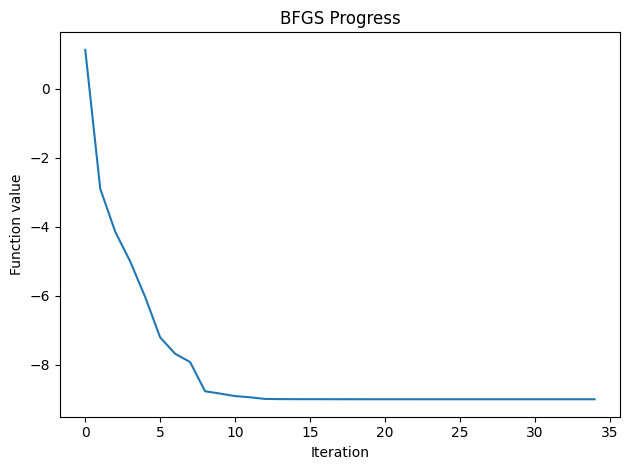

In [121]:
plt.plot(history)
plt.xlabel('Iteration')
plt.ylabel('Function value')
plt.title('BFGS Progress')
plt.grid(False)
plt.tight_layout()
plt.show()

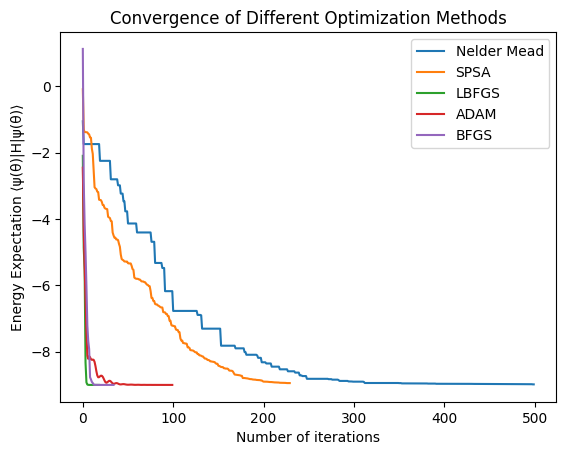

In [126]:
import matplotlib.pyplot as plt

y1 = fhisto
y2 = f_history
y3 = fhist
y4 = fhistory
y5 = history

# Generate corresponding x-values automatically
x1 = list(range(len(y1)))
x2 = list(range(len(y2)))
x3 = list(range(len(y3)))
x4 = list(range(len(y4)))
x5 = list(range(len(y5)))

# Plot each with its own x
plt.plot(x1, y1, label='Nelder Mead')
plt.plot(x2, y2, label='SPSA')
plt.plot(x3, y3, label='LBFGS')
plt.plot(x4, y4, label='ADAM')
plt.plot(x5, y5, label='BFGS')

plt.xlabel('Number of iterations')
plt.ylabel('Energy Expectation ⟨ψ(θ)|H|ψ(θ)⟩')
plt.title('Convergence of Different Optimization Methods')
plt.legend()
plt.grid(False)
plt.show()



In [127]:
from scipy.optimize import minimize
theta0 = np.random.uniform(0, 3*np.pi, size=(n_layers*n_qubits))
print("Initial θ:", theta0)
# Optimize using classical optimizer (e.g., BFGS)
result = minimize(cost, theta0, method='BFGS', options={'disp': True})

# Final optimized value
print("\n[BFGS] Optimal energy ⟨ψ(θ)|H|ψ(θ)⟩:", result.fun)
print("[BFGS] Optimal θ:", result.x)


Initial θ: [6.17539558 2.54589731 3.29050801 9.35198719 5.99854446 8.22714596
 7.61303888 6.147524   7.92368493 2.70640506 6.00468107 5.56630675
 5.86616654 1.58931847 2.61295409 2.70169101 5.67320893 9.1660384
 8.99187483 2.14121109]


KeyboardInterrupt: 

In [53]:
theta0 = np.random.uniform(0, 3*np.pi, size=n_qubits*n_layers)
# Run Nelder-Mead
result_nm = minimize(cost, theta0, method='Nelder-Mead', options={'disp': True})

print("[Nelder-Mead] Optimal value:", result_nm.fun)
print("[Nelder-Mead] Optimal θ:", result_nm.x)


Optimization terminated successfully.
         Current function value: -7.000000
         Iterations: 2291
         Function evaluations: 3034
[Nelder-Mead] Optimal value: -6.999999986802893
[Nelder-Mead] Optimal θ: [8.7114493  7.85395726 4.71242364 4.71238776 7.85394076 1.57086633
 4.71242338 1.57077262 0.71329168 4.71238393 1.57079623 4.71232289
 7.85398211 0.78487941 4.71245027 1.57078481]


In [ ]:
#Projective measurement

In [128]:
def sample_bitstrings(statevector, n_samples):
    probs = np.abs(statevector) ** 2
    assert np.isclose(np.sum(probs), 1.0), "Probabilities must sum to 1"
    outcomes = np.random.choice(len(probs), size=n_samples, p=probs) 
    bitstrings = [format(i, f'0{n_qubits}b') for i in outcomes]
    return bitstrings


In [131]:
theta = solnm  # example parameters
state = ansatz(theta, n_qubits, n_layers)
bitstrings = sample_bitstrings(state , 10000)
print(bitstrings)
print("Sampled bitstrings:", len(bitstrings))

['1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101011', '1010101010', '1010101011', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010101010', '1010

In [132]:
def generate_hamiltonian(n_qubits=9):
    hamiltonian = []

    # Single-qubit terms:
    for i in range(n_qubits):
        hamiltonian.append((1.0, [i]))

    # Two-qubit terms
    for i in range(n_qubits - 1):
        hamiltonian.append((1.0, [i, i + 1]))
    return hamiltonian

hamiltonian_terms = generate_hamiltonian(n_qubits)

In [133]:
def estimate_expectation(bitstrings, hamiltonian_terms):
    total = 0
    for bitstring in bitstrings:
        val = 0
        for coeff, qubits in hamiltonian_terms:
            product = 1
            for q in qubits:
                product *= 1 if bitstring[q] == '0' else -1  # Z|0>=+1, Z|1>=-1
            val += coeff * product
        total += val
    return total / len(bitstrings)

In [134]:
expect_val = estimate_expectation(bitstrings, hamiltonian_terms)
print("Estimated ⟨H⟩ =", expect_val)

Estimated ⟨H⟩ = -8.9812


In [135]:
def bitstring_energy(bitstring, hamiltonian_terms):
    val = 0
    for coeff, qubits in hamiltonian_terms:
        product = 1
        for q in qubits:
            product *= 1 if bitstring[q] == '0' else -1  # Z|0>=+1, Z|1>=-1
        val += coeff * product
    return val


In [136]:
from collections import Counter
bitstring_counts = Counter(bitstrings)
bitstring_data = []
for bitstring, count in bitstring_counts.items():
    energy = bitstring_energy(bitstring, hamiltonian_terms)
    bitstring_data.append((bitstring, count, energy))
print(bitstring_data)


[('1010101010', 9157, -9.0), ('1010101011', 366, -9.0), ('1101010101', 291, -9.0), ('1010110101', 129, -9.0), ('1101001010', 5, -5.0), ('1010110100', 4, -5.0), ('1101010100', 18, -5.0), ('1010101001', 3, -7.0), ('0001010101', 1, -3.0), ('1100010100', 1, 1.0), ('1000101010', 2, -3.0), ('1100010101', 1, -3.0), ('1011101010', 10, -7.0), ('1010111010', 8, -7.0), ('1011010101', 2, -9.0), ('1010100101', 2, -7.0)]


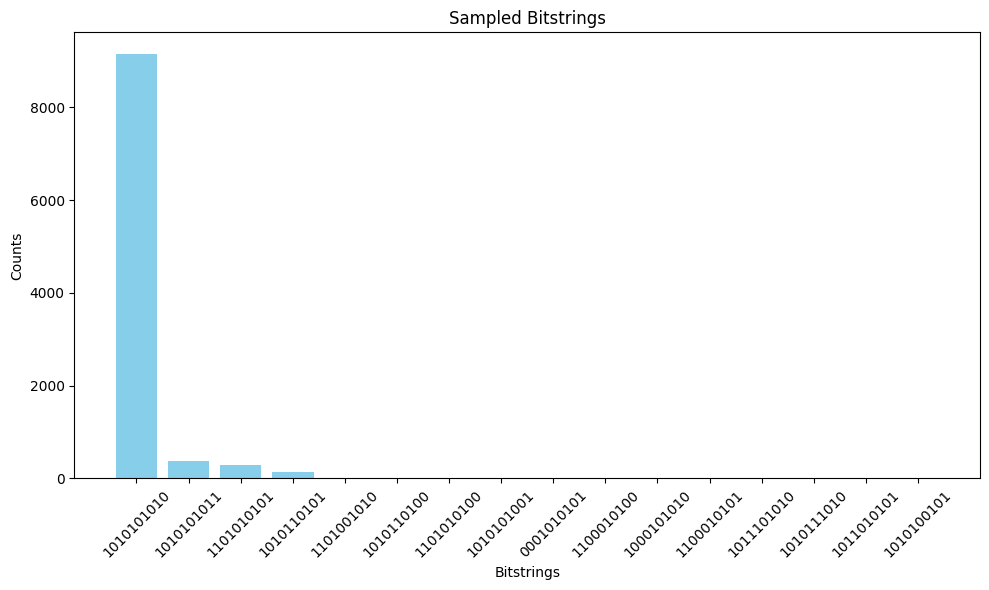

In [137]:
bitstrings_unique = list(bitstring_counts.keys())
frequencies = list(bitstring_counts.values())
plt.figure(figsize=(10,6))
plt.bar(bitstrings_unique, frequencies, color='skyblue')
plt.xlabel('Bitstrings')
plt.ylabel('Counts')
plt.title('Sampled Bitstrings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Symbolic Ising Hamiltonian:

H = 0.954 * Z_6 Z_7 + 0.969 * Z_3 Z_5 + 0.828 * Z_3 Z_6 + 0.374 * Z_7 Z_9 + 0.188 * Z_5 Z_6 + 0.716 * Z_6 Z_9 + 0.496 * Z_0 Z_5 + 0.210 * Z_1 Z_5 + 0.546 * Z_0 Z_9 + 0.131 * Z_0 Z_4 + 0.918 * Z_0 Z_7 + 0.333 * Z_3 Z_4 + 0.696 * Z_4 Z_7 + 0.381 * Z_2 Z_5 + 0.568 * Z_2 Z_3 + 0.592 * Z_1 Z_6 + 0.266 * Z_7 Z_8 + 0.973 * Z_1 Z_8 + 0.798 * Z_1 Z_2 + 0.946 * Z_1 Z_9

Qubit Connectivity Edges:
 [(6, 7), (3, 5), (3, 6), (7, 9), (5, 6), (6, 9), (0, 5), (1, 5), (0, 9), (0, 4), (0, 7), (3, 4), (4, 7), (2, 5), (2, 3), (1, 6), (7, 8), (1, 8), (1, 2), (1, 9)]


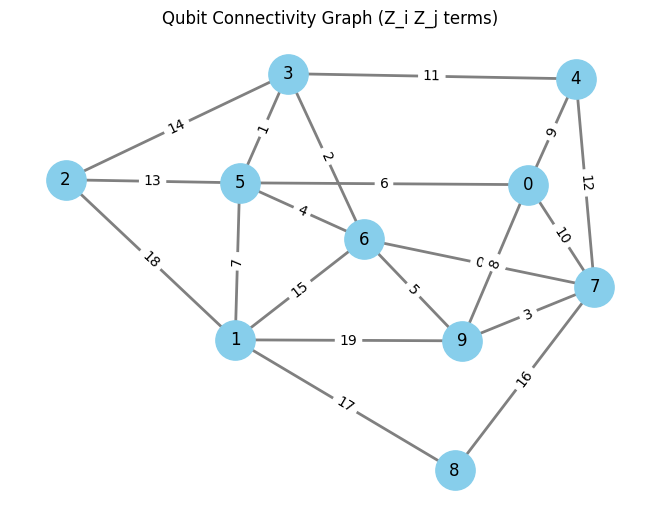

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations

# Pauli matrices
I = np.eye(2)
Z = np.array([[1, 0], [0, -1]])

# Tensor product operator constructor
def kron_n(*ops):
    result = ops[0]
    for op in ops[1:]:
        result = np.kron(result, op)
    return result

# Builds two-qubit operator like Z_i Z_j
def build_two_qubit_operator(op1, i, op2, j, n_qubits):
    ops = [I] * n_qubits
    ops[i] = op1
    ops[j] = op2
    return kron_n(*ops)

# Generate symbolic + numerical Ising Hamiltonian
def ising_hamiltonian_symbolic(n_qubits, n_edges, seed):
    np.random.seed(seed)

    dim = 2 ** n_qubits
    H = np.zeros((dim, dim), dtype=np.float64)
    symbolic_terms = []

    # Generate random edges
    all_edges = list(combinations(range(n_qubits), 2))
    selected_edge_indices = np.random.choice(len(all_edges), size=n_edges, replace=False)
    selected_edges = [all_edges[idx] for idx in selected_edge_indices]

    # Add Z_i Z_j interaction terms
    for i, j in selected_edges:
        J = np.random.uniform(0.1, 1.0)  # Positive coupling
        term_matrix = build_two_qubit_operator(Z, i, Z, j, n_qubits)
        H += J * term_matrix
        symbolic_terms.append(f"{J:.3f} * Z_{i} Z_{j}")

    symbolic_H = " + ".join(symbolic_terms)
    return H, selected_edges, symbolic_H

# Visualize the qubit connectivity graph
def plot_connectivity_graph(n_qubits, edges):
    G = nx.Graph()
    G.add_nodes_from(range(n_qubits))
    G.add_edges_from(edges)

    pos = nx.spring_layout(G, seed=42)  # consistent layout
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=800, edge_color='gray', width=2)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={e: f"{i}" for i, e in enumerate(edges)})
    plt.title("Qubit Connectivity Graph (Z_i Z_j terms)")
    plt.axis('off')
    plt.show()

# 🔁 Example usage
n_qubits = 10
n_edges = 20
seed = 42

H, edges, symbolic = ising_hamiltonian_symbolic(n_qubits, n_edges, seed)

print("Symbolic Ising Hamiltonian:\n")
print("H =", symbolic)
print("\nQubit Connectivity Edges:\n", edges)

plot_connectivity_graph(n_qubits, edges)


In [158]:
import itertools
import numpy as np

# List of (i, j, J_ij) terms from your Hamiltonian
terms = [
    (1, 2, 0.470),
    (0, 1, 0.622),
    (2, 3, 0.226),
    (1, 3, 0.461),
    (2, 4, 0.665),
    (0, 4, 0.392)
]

# Generate all 32 configurations
configs = list(itertools.product([-1, 1], repeat=5))

# Compute energy for each configuration
min_energy = float('inf')
best_config = None

for s in configs:
    energy = 0
    for i, j, J in terms:
        energy += J * s[i] * s[j]
    if energy < min_energy:
        min_energy = energy
        best_config = s

print("Ground state energy:", min_energy)
print("Best configuration (Z eigenvalues):", best_config)


Ground state energy: -2.3840000000000003
Best configuration (Z eigenvalues): (-1, 1, -1, -1, 1)
